In [2]:
from time import perf_counter as timerpc

import matplotlib.pyplot as plt
import numpy as np

from floris import FlorisModel
from floris.optimization.yaw_optimization.yaw_optimizer_geometric import (
    YawOptimizationGeometric,
)
from floris.optimization.yaw_optimization.yaw_optimizer_scipy import YawOptimizationScipy
from floris.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR


# Load the default example floris object
fmodel = FlorisModel("data/gch.yaml")

# Reinitialize as a 3-turbine farm with range of WDs and 1 WS
D = 126.0 # Rotor diameter for the NREL 5 MW
wd_array = np.arange(0.0, 360.0, 3.0)
ws_array = 8.0 * np.ones_like(wd_array)
turbulence_intensities = 0.06 * np.ones_like(wd_array)
fmodel.set(
    layout_x=[0.0, 250.0, 0.0, 250.0],#[0.0, 5 * D, 10 * D],
    layout_y=[0.0, 0.0, 250.0, 250.0],#[0.0, 0.0, 0.0],
    wind_directions=wd_array,
    wind_speeds=ws_array,
    turbulence_intensities=turbulence_intensities,
)

print("Performing optimizations with SciPy...")
start_time = timerpc()
yaw_opt_scipy = YawOptimizationScipy(fmodel)
df_opt_scipy = yaw_opt_scipy.optimize()
time_scipy = timerpc() - start_time

print("Performing optimizations with Serial Refine...")
start_time = timerpc()
yaw_opt_sr = YawOptimizationSR(fmodel)
df_opt_sr = yaw_opt_sr.optimize()
time_sr = timerpc() - start_time

print("Performing optimizations with Geometric Yaw...")
start_time = timerpc()
yaw_opt_geo = YawOptimizationGeometric(fmodel)
df_opt_geo = yaw_opt_geo.optimize()
time_geo = timerpc() - start_time



# Print time spent
print("\n Time spent, Geometric Yaw: {:.2f} s.".format(time_geo))
print(" Time spent, Serial Refine: {:.2f} s.".format(time_sr))
print(" Time spent, SciPy (SLSQP): {:.2f} s.\n".format(time_scipy))

# Split out the turbine results
yaw_angles_opt_geo = np.vstack(df_opt_geo.yaw_angles_opt)
yaw_angles_opt_sr = np.vstack(df_opt_sr.yaw_angles_opt)
yaw_angles_opt_scipy = np.vstack(df_opt_scipy.yaw_angles_opt)


# Yaw results
for t in range(3):
    fig, ax = plt.subplots()
    ax.plot(df_opt_geo.wind_direction, yaw_angles_opt_geo[:, t],color='m',label='Geometric')
    ax.plot(df_opt_sr.wind_direction, yaw_angles_opt_sr[:, t],color='r',label='Serial Refine')
    ax.plot(df_opt_scipy.wind_direction, yaw_angles_opt_scipy[:, t],'--', color='g', label='SciPy')
    ax.grid(True)
    ax.set_ylabel('Yaw Offset (deg')
    ax.legend()
    ax.grid(True)
    ax.set_title("Turbine {:d}".format(t))

# Power results ==============

# Before plotting results, need to compute values for GEOOPT since it doesn't compute
# power within the optimization
fmodel.set(yaw_angles=yaw_angles_opt_geo)
fmodel.run()
geo_farm_power = fmodel.get_farm_power().squeeze()


fig, ax = plt.subplots()
ax.plot(
    df_opt_sr.wind_direction,
    df_opt_sr.farm_power_baseline,
    color='k',
    label='Baseline'
)
ax.plot(
    df_opt_geo.wind_direction,
    geo_farm_power,
    color='m',
    label='Optimized, Gemoetric'
)
ax.plot(
    df_opt_sr.wind_direction,
    df_opt_sr.farm_power_opt,
    color='r',
    label='Optimized, Serial Refine'
)
ax.plot(
    df_opt_scipy.wind_direction,
    df_opt_scipy.farm_power_opt,
    '--',
    color='g',
    label='Optimized, SciPy'
)
ax.set_ylabel('Wind Farm Power (W)')
ax.set_xlabel('Wind Direction (deg)')
ax.legend()
ax.grid(True)

# Finally, compare the overall the power gains

fig, ax = plt.subplots()

ax.plot(
    df_opt_geo.wind_direction,
    geo_farm_power - df_opt_sr.farm_power_baseline,
    color='m',
    label='Optimized, Gemoetric'
)
ax.plot(
    df_opt_sr.wind_direction,
    df_opt_sr.farm_power_opt - df_opt_sr.farm_power_baseline,
    color='r',
    label='Optimized, Serial Refine'
)
ax.plot(
    df_opt_scipy.wind_direction,
    df_opt_scipy.farm_power_opt - df_opt_scipy.farm_power_baseline,
    '--',
    color='g',
    label='Optimized, SciPy'
)
ax.set_ylabel('Increase in Wind Farm Power (W)')
ax.set_xlabel('Wind Direction (deg)')
ax.legend()
ax.grid(True)


# Finally, make a quick bar plot comparing nomimal power and nomimal uplift
total_power_uplift_geo = np.sum(geo_farm_power - df_opt_sr.farm_power_baseline)
total_power_uplift_sr = np.sum(df_opt_sr.farm_power_opt - df_opt_sr.farm_power_baseline)
total_power_uplift_scipy = np.sum(df_opt_scipy.farm_power_opt - df_opt_scipy.farm_power_baseline)

# Plot on the left subplot a barplot comparing the uplift normalized to scipy and on the right
# subplot a barplot of total time normalzed to scipy
fig, axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
ax.bar(
    [0, 1, 2],
    [
        total_power_uplift_geo / total_power_uplift_scipy,
        total_power_uplift_sr / total_power_uplift_scipy,
        1.0,
    ],
    color=['m', 'r', 'g'],
)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Geometric', 'Serial Refine', 'SciPy'])
ax.set_ylabel('Normalized Power Gain')
ax.grid(True)

ax = axarr[1]
ax.bar(
    [0, 1, 2],
    [
        time_geo / time_scipy,
        time_sr / time_scipy,
        1.0,
    ],
    color=['m', 'r', 'g'],
)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Geometric', 'Serial Refine', 'SciPy'])
ax.set_ylabel('Normalized Computation Time')
ax.grid(True)

# Change to semi-logy
axarr[1].set_yscale('log')

plt.show()
import warnings
warnings.filterwarnings('ignore')

Performing optimizations with Serial Refine...
[Serial Refine] Processing pass=0, turbine_depth=0 (0.0%)
[Serial Refine] Processing pass=0, turbine_depth=1 (12.5%)
[Serial Refine] Processing pass=0, turbine_depth=2 (25.0%)
[Serial Refine] Processing pass=0, turbine_depth=3 (37.5%)
[Serial Refine] Processing pass=1, turbine_depth=0 (50.0%)
[Serial Refine] Processing pass=1, turbine_depth=1 (62.5%)
[Serial Refine] Processing pass=1, turbine_depth=2 (75.0%)
[Serial Refine] Processing pass=1, turbine_depth=3 (87.5%)


ZeroDivisionError: division by zero

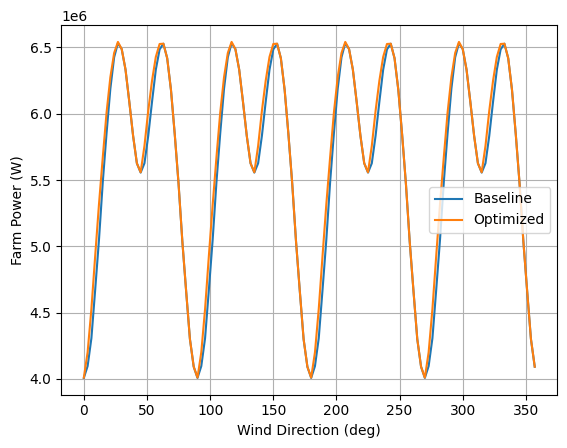

In [2]:
from pathlib import Path
Path("data/serial_refine").mkdir(parents=True, exist_ok=True)

np.save("data/serial_refine/wind_direction", df_opt_sr.wind_direction)
np.save("data/serial_refine/farm_power_opt", df_opt_sr.farm_power_opt)

# Plot them
fig, ax = plt.subplots()
ax.plot(df_opt_sr.wind_direction, df_opt_sr.farm_power_baseline, label="Baseline")
ax.plot(df_opt_sr.wind_direction, df_opt_sr.farm_power_opt, label="Optimized")
ax.set_xlabel("Wind Direction (deg)")
ax.set_ylabel("Farm Power (W)")
ax.legend()
ax.grid(True)
plt.show()
